In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [10]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_16.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [6]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 24, 24)
in (8075, 56, 56)   out (8075, 24, 24)


In [7]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 24, 24, 1)
(8075, 56, 56, 1) (8075, 24, 24, 1)


In [8]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

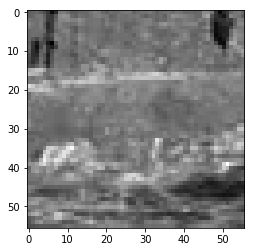

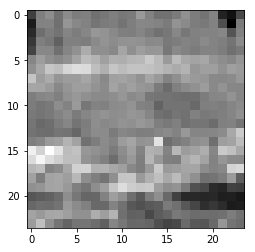

In [9]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

In [11]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2950

In [64]:
# from keras.callbacks import Callback

# # taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

# class LRPrintCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = self.model.optimizer.lr
#         decay = self.model.optimizer.decay
#         iterations = self.model.optimizer.iterations
#         lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
#         print(K.eval(lr_with_decay))
#         print(K.eval(lr))
#         print(K.eval(decay))
        
# lr_printer = LRPrintCallback()

In [13]:
# model_version_previous = '0.0.2.0.0_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12'
# brief_ae_previous = load_model('./weights/ready' + '/brief_ae_' + model_version_previous + '.h5')

In [15]:
# brief_ae_previous.get_layer(index=7)

In [14]:
# brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [19]:
# for i in range(7, 13):
#     print(brief_ae_previous.get_layer(index=i))
#     brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [61]:
# brief_ae = load_model('/scratch/image_datasets/2_for_learned_brief/ridiculously_small/brief_ae_0.0.0.3.4_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs.h5')
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.01, rho=0.95)
# # my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, decay=0.95)
# brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")

In [ ]:
model_version = '0.0.3.0.0_decoder128_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=50,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/50
64598/64598 [==============================] - 2032s 31ms/step - loss: 0.6373 - val_loss: 0.6594
Epoch 2/50
64598/64598 [==============================] - 2033s 31ms/step - loss: 0.6265 - val_loss: 0.6314
Epoch 3/50
64598/64598 [==============================] - 2031s 31ms/step - loss: 0.6229 - val_loss: 0.6190
Epoch 4/50
19461/64598 [========>.....................] - ETA: 21:55 - loss: 0.6212

In [14]:
history_callback.history

{'val_loss': [0.6593759059906006,
  0.6313798427581787,
  0.6190268993377686,
  0.6259757876396179,
  0.6632239818572998,
  0.5910078883171082,
  0.6442290544509888,
  0.6320494413375854,
  0.6114718914031982,
  0.634005069732666,
  0.617868959903717,
  0.5983189344406128,
  0.6404947638511658,
  0.6600907444953918,
  0.6061193346977234,
  0.5735254883766174,
  0.5997149348258972,
  0.6177098751068115,
  0.5930907726287842,
  0.6613056063652039,
  0.5979640483856201,
  0.6010193824768066,
  0.6229335069656372,
  0.6247256398200989,
  0.6561582088470459,
  0.6345827579498291,
  0.6105645298957825,
  0.6336223483085632,
  0.5743504762649536,
  0.5557993650436401,
  0.6437798738479614,
  0.6079597473144531,
  0.6606602668762207,
  0.662793755531311,
  0.6153638362884521,
  0.62119460105896,
  0.6167016625404358,
  0.5913792252540588,
  0.6141979694366455,
  0.6119444370269775,
  0.6236250996589661,
  0.6298884749412537,
  0.5991315841674805,
  0.5723130702972412,
  0.6222501993179321,
  0

predictions: 


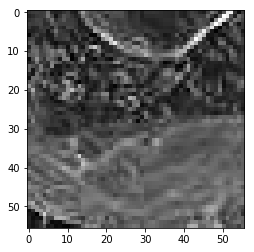

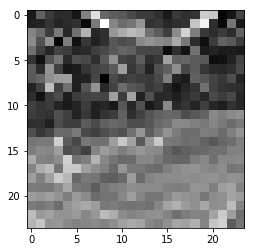

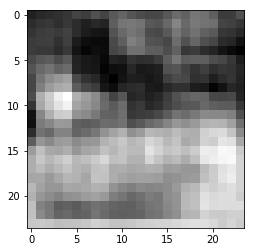

39.98478323221207

 next


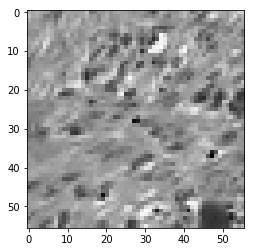

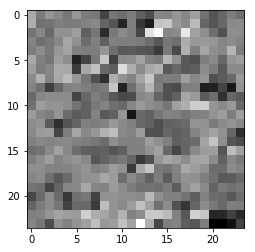

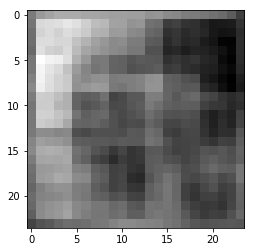

45.21125078201294

 next


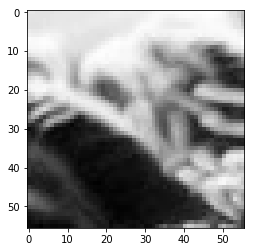

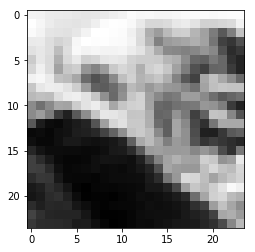

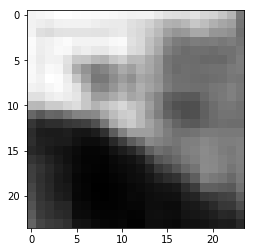

42.549250423908234

 next


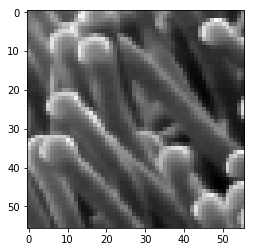

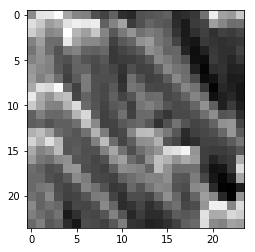

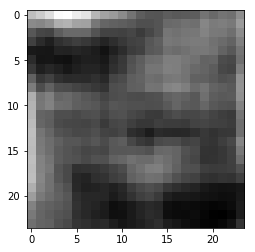

27.25314650684595

 next


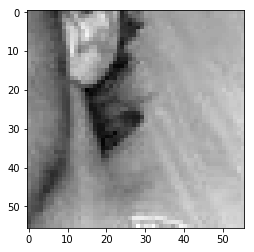

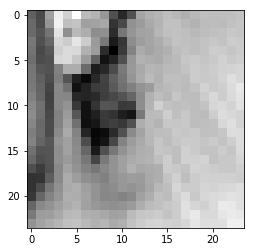

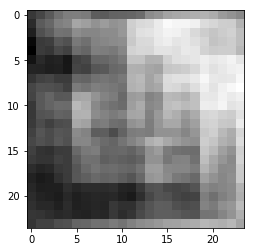

30.883705392479897

 next


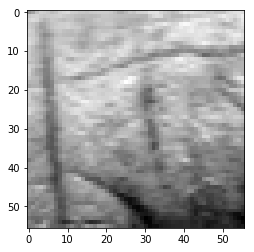

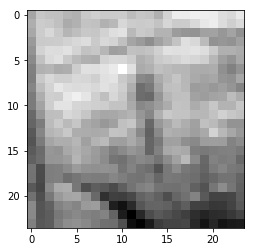

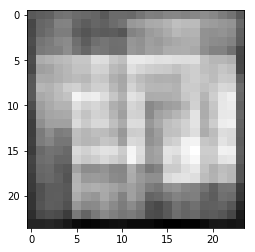

58.46018984913826

 next


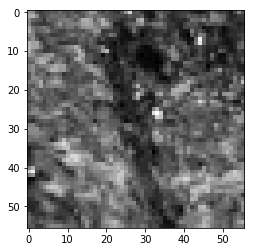

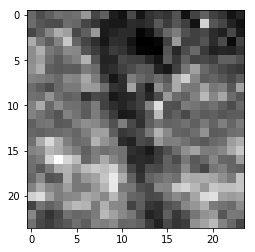

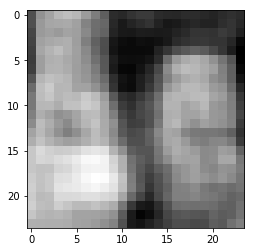

45.88665314018726

 next


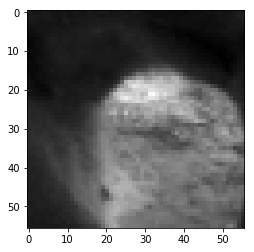

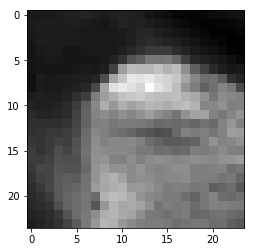

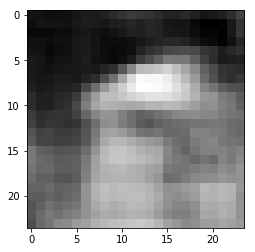

19.343071058392525

 next


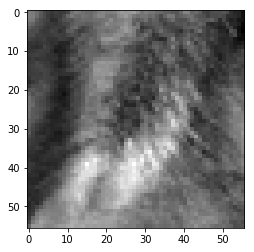

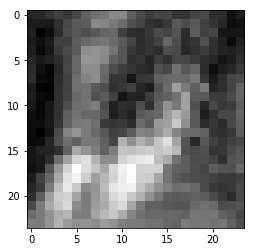

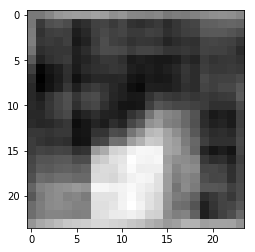

22.575815990567207

 next


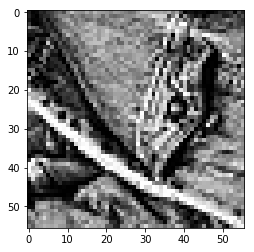

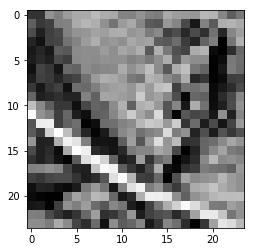

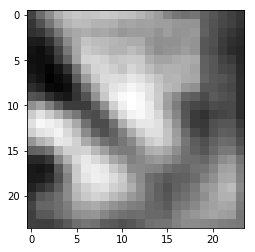

54.17574495077133

 next


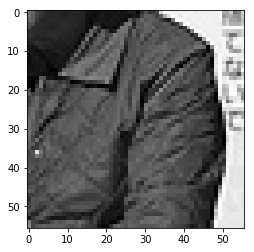

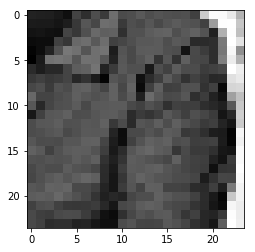

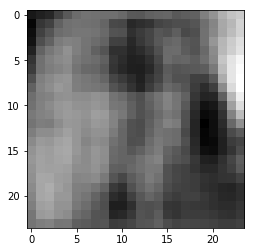

48.79548065364361

 next


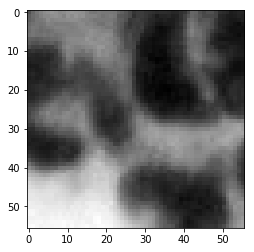

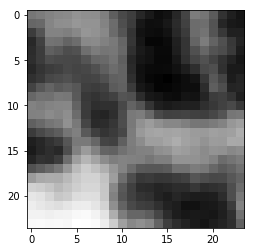

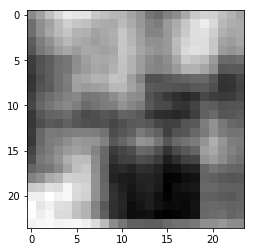

24.015997610986233

 next


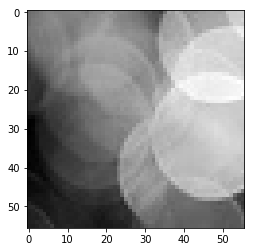

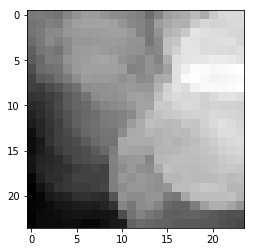

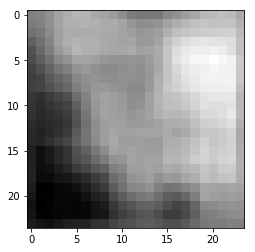

34.26105536520481

 next


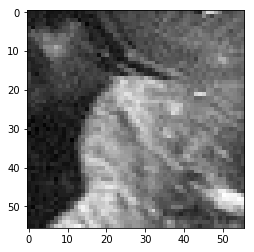

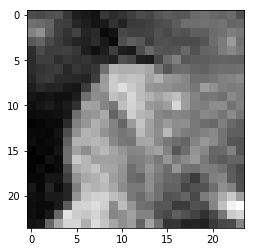

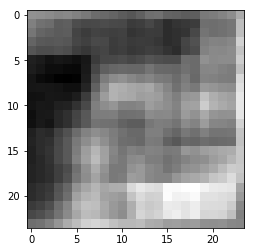

21.867853179574013

 next


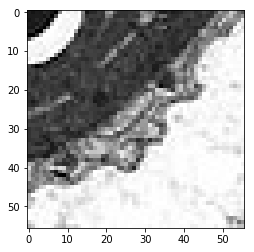

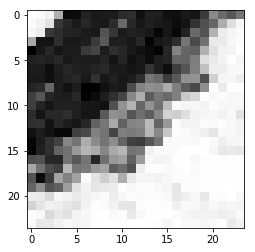

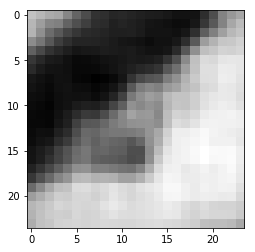

42.17735297977924

 next


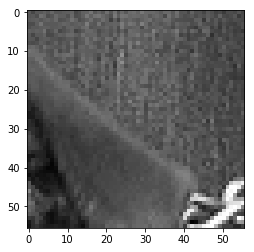

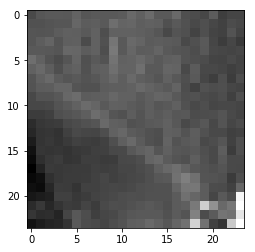

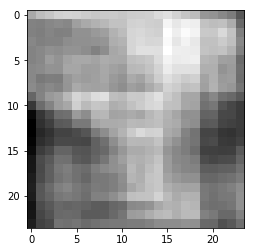

30.747351609170437

 next


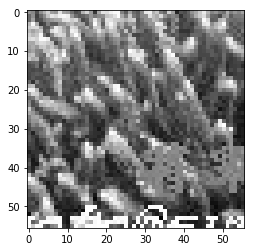

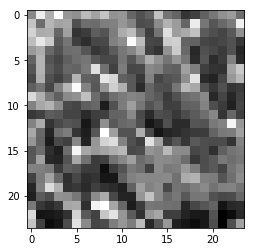

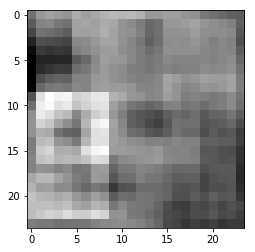

41.05688810348511

 next


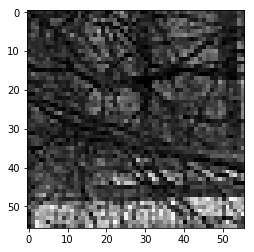

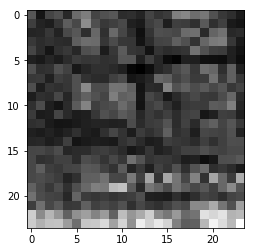

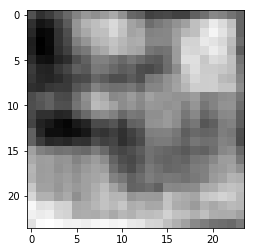

55.40307529270649

 next


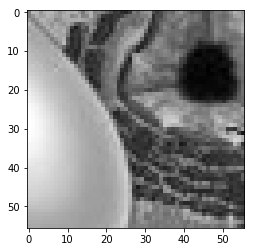

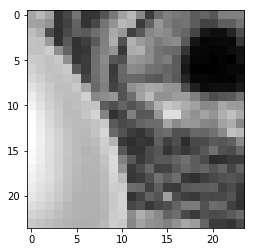

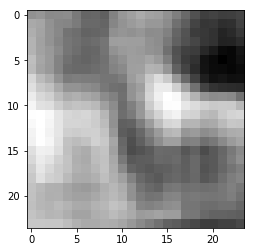

29.25278350710869

 next


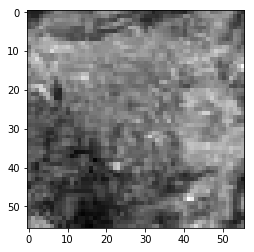

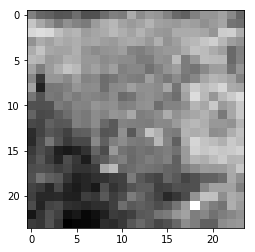

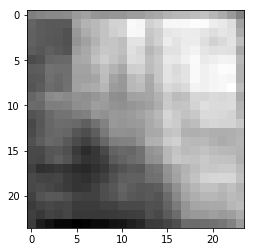

14.636154379695654

 next


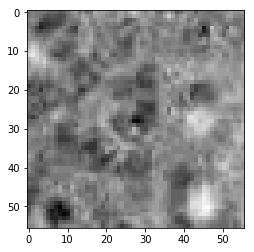

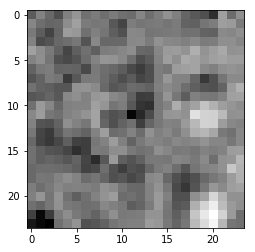

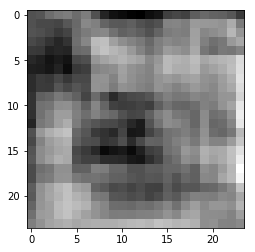

60.14058127999306

 next


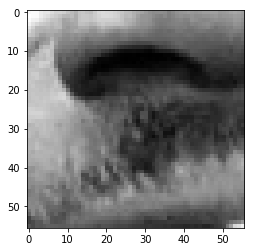

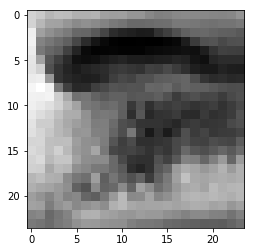

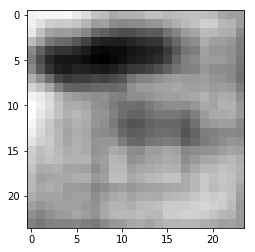

53.9654528349638

 next


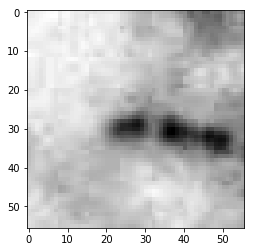

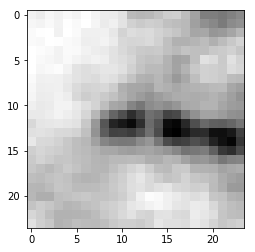

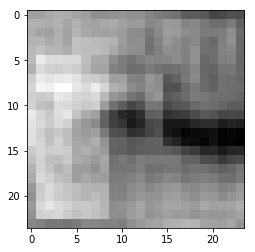

32.56453759968281

 next


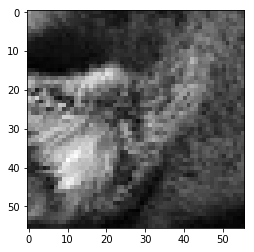

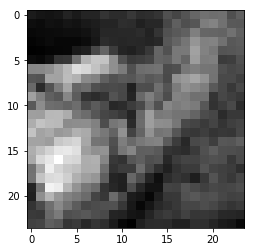

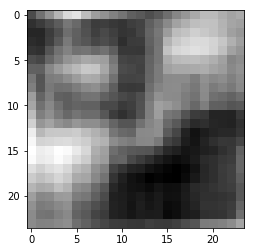

35.66493563354015

 next


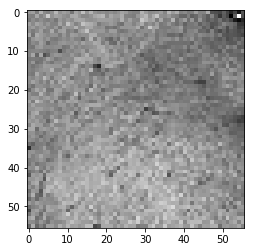

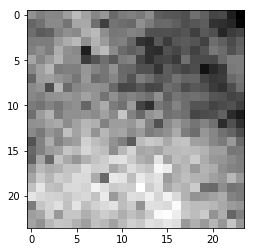

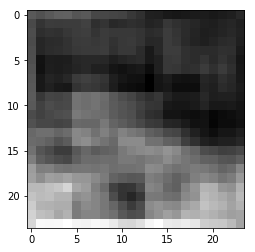

63.73062863945961

 next


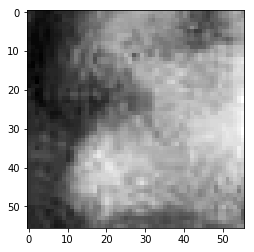

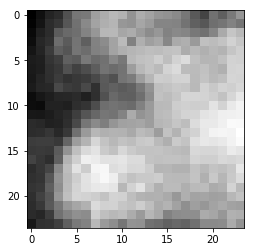

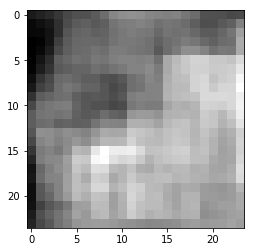

29.620048999786377

 next


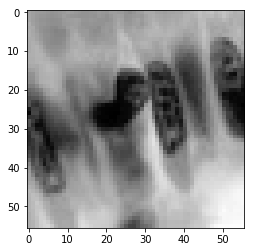

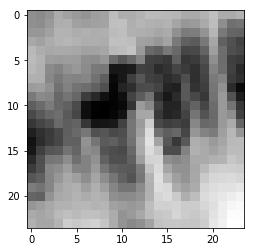

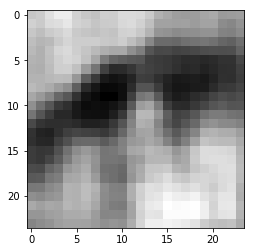

24.814021289348602

 next


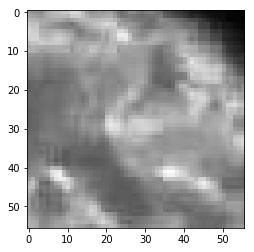

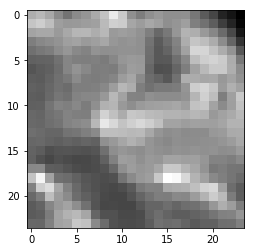

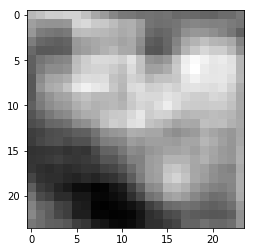

18.701654076576233

 next


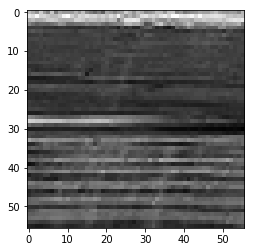

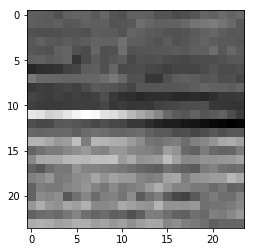

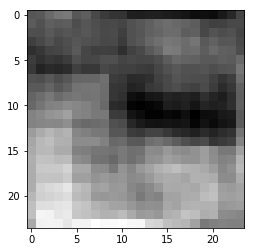

34.43182960152626

 next


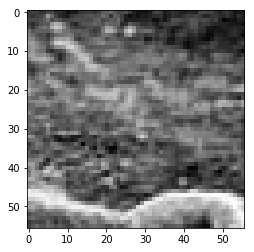

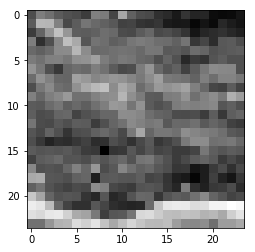

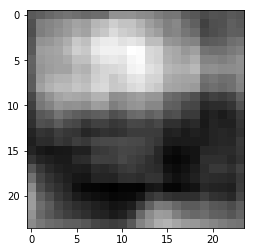

76.33867129683495

 next


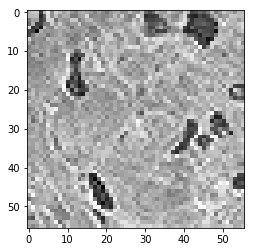

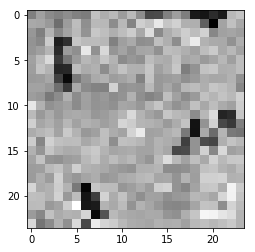

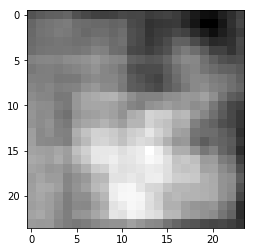

60.03544472157955

 next


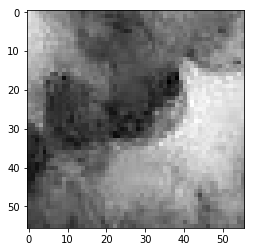

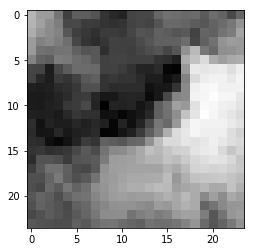

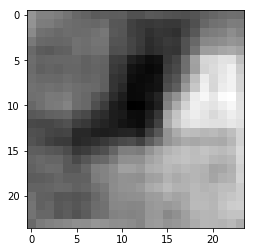

33.204674050211906

 next


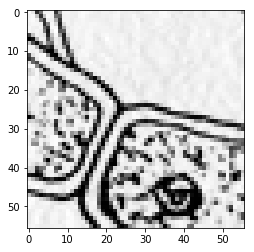

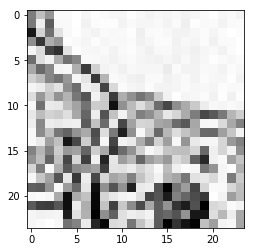

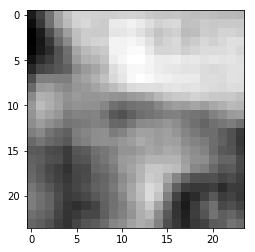

66.4390929043293

 next


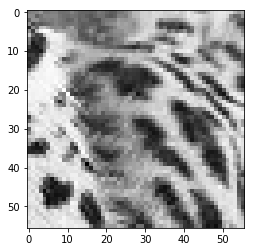

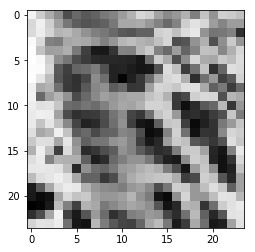

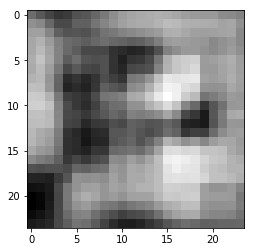

51.93750165402889

 next


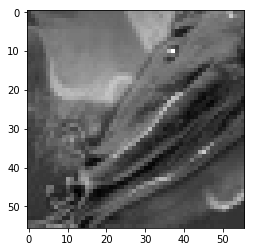

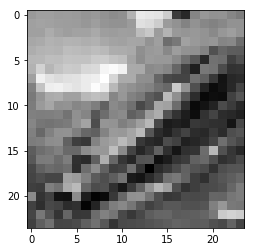

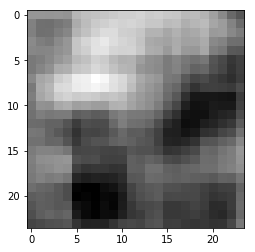

21.013326533138752

 next


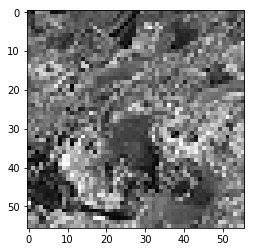

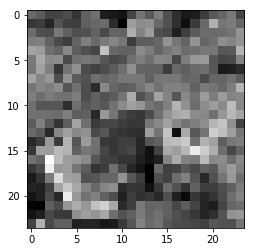

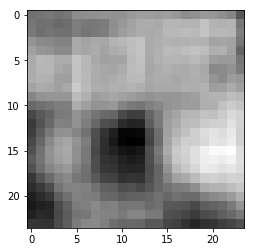

40.49842827022076

 next


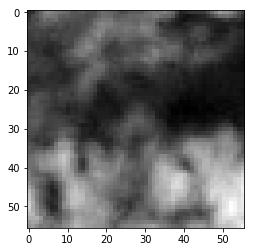

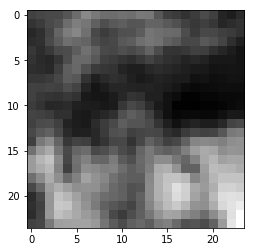

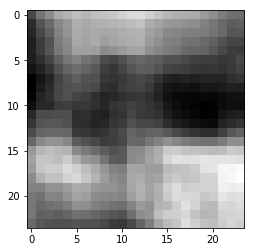

36.0890194773674

 next


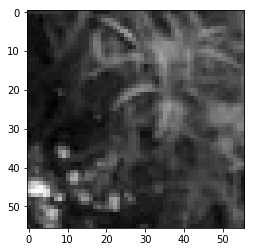

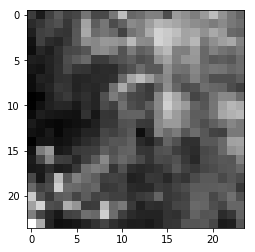

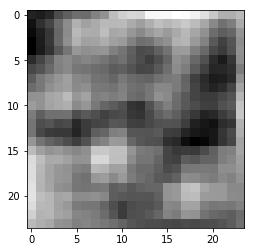

56.89478024840355

 next


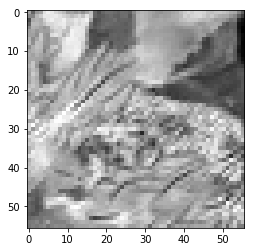

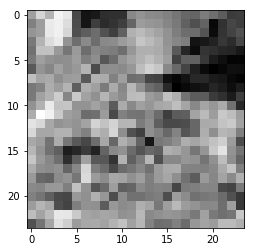

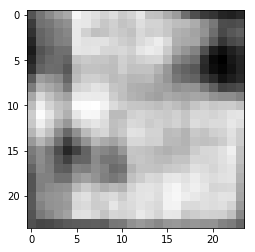

42.90926210582256

 next


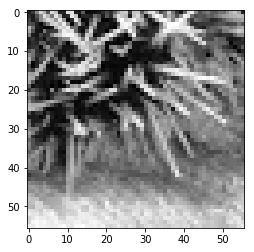

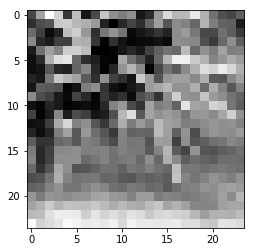

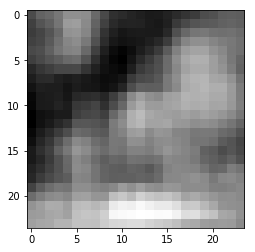

39.635977149009705

 next


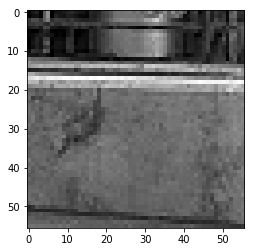

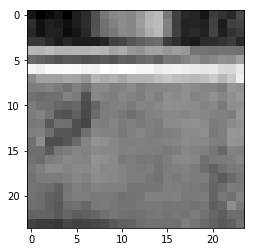

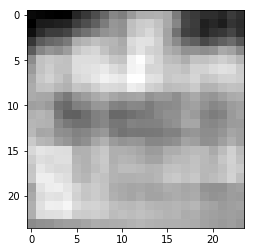

55.472539365291595

 next


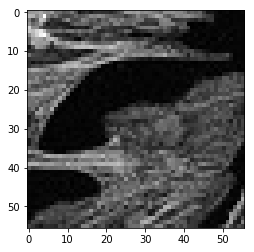

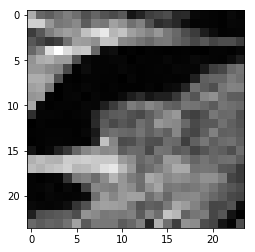

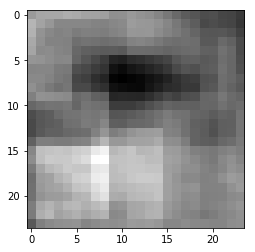

89.22771647572517

 next


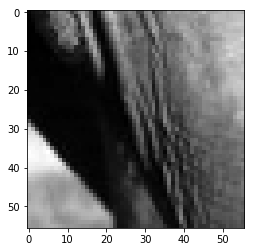

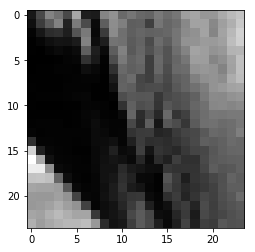

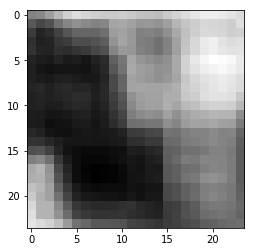

35.44057287275791

 next


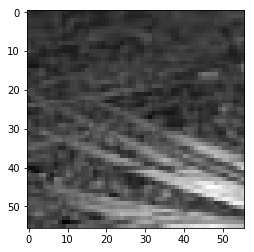

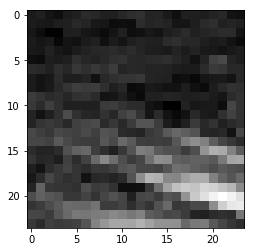

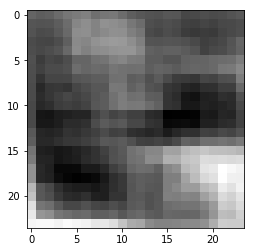

22.66291681677103

 next


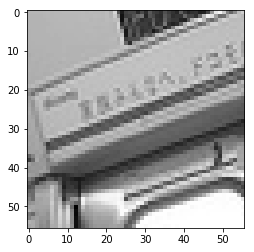

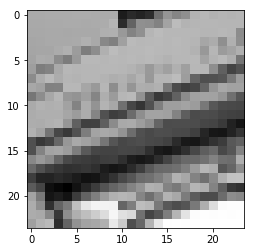

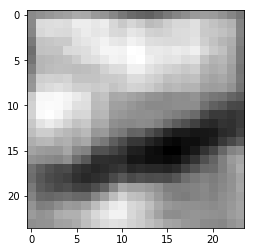

39.623107239603996

 next


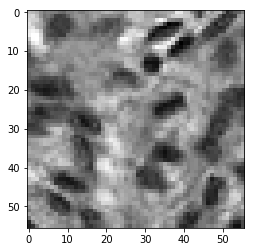

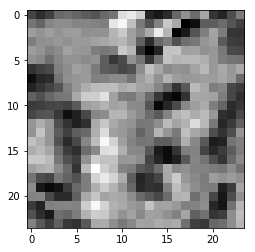

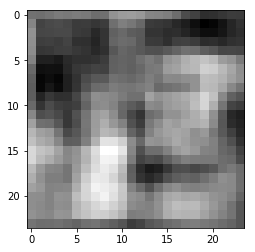

32.251643389463425

 next


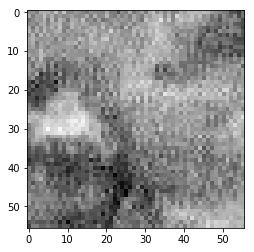

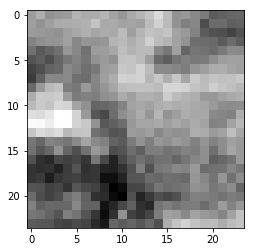

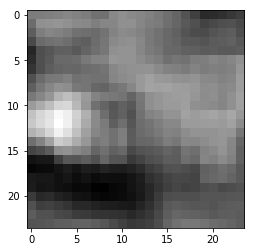

22.141497395932674

 next


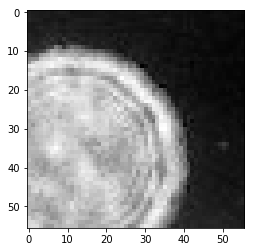

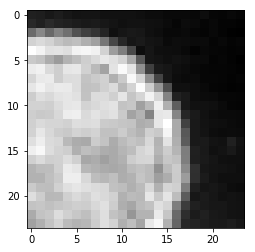

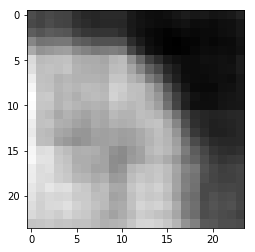

41.62347950041294

 next


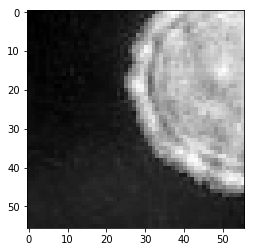

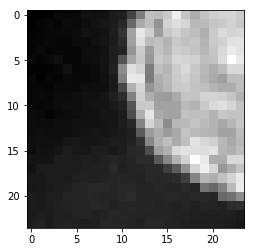

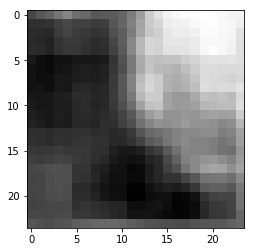

61.29182070493698

 next


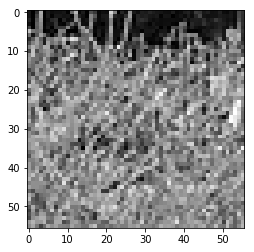

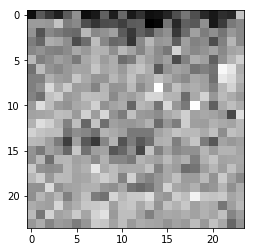

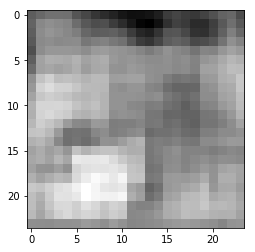

29.876744225621223

 next


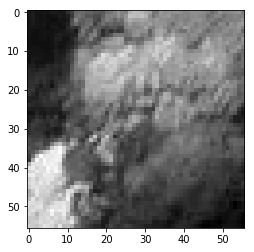

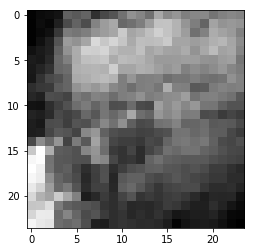

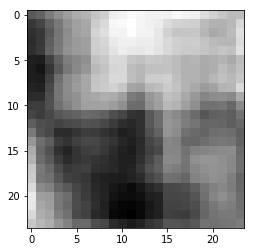

31.510394364595413

 next


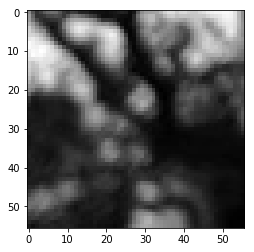

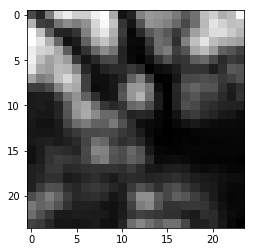

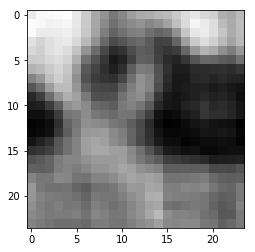

56.05086453258991

 next


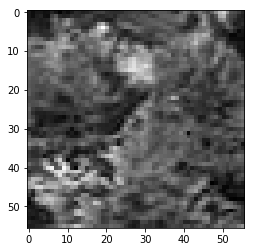

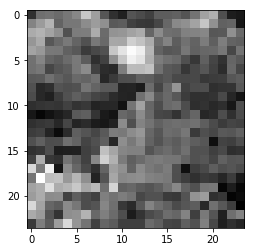

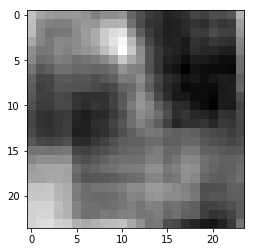

71.63885548710823

 next


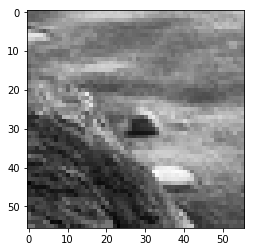

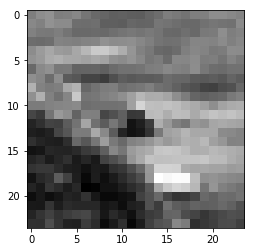

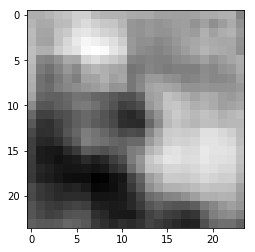

24.935996644198895

 next


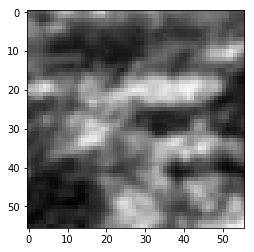

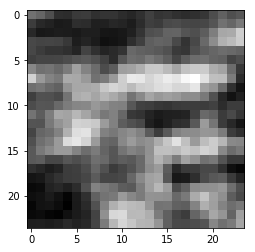

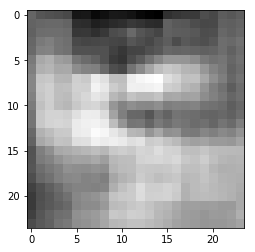

26.29759658128023

 next


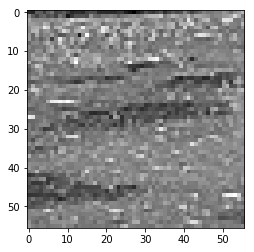

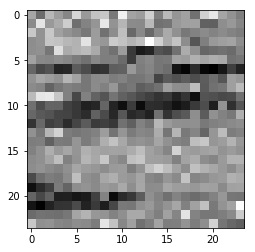

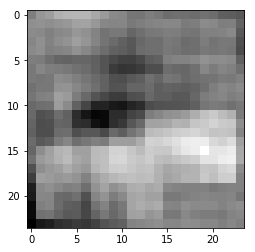

27.558760307729244

 next


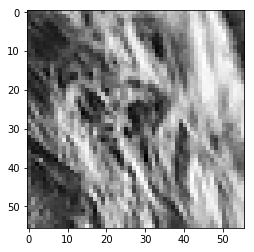

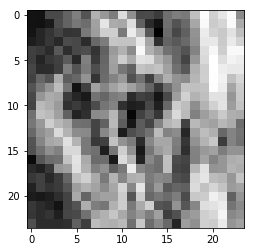

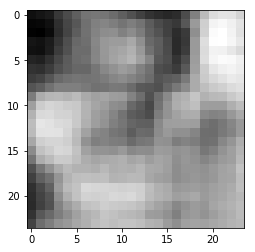

40.560725927352905

 next


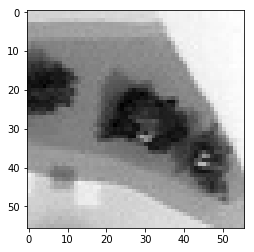

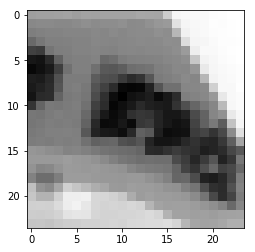

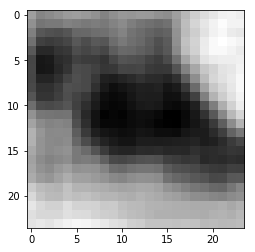

26.371508315205574

 next


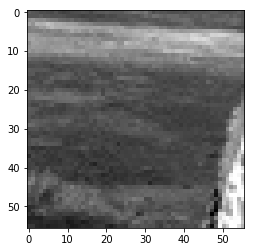

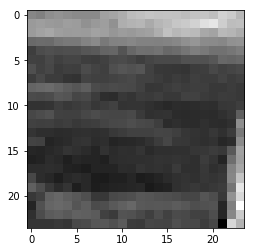

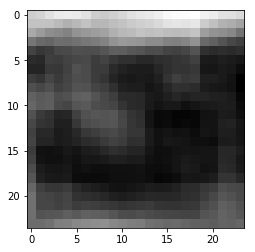

31.876060143113136

 next


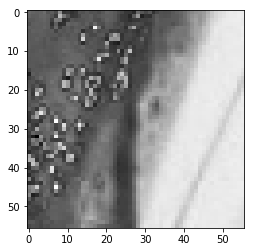

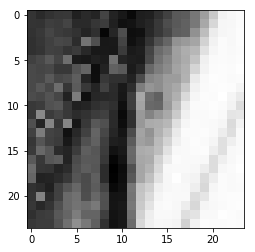

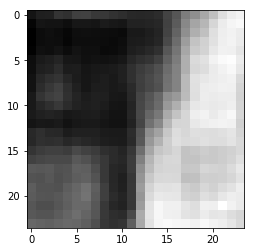

53.66270788013935

 next


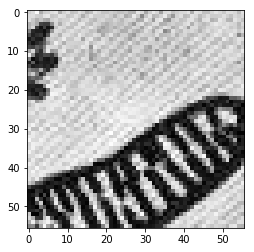

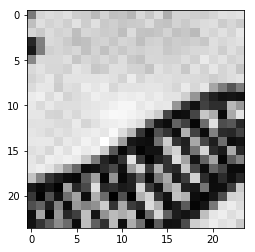

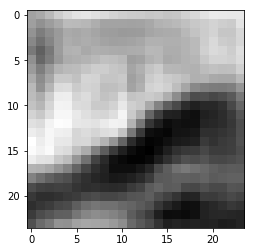

60.10745085775852

 next


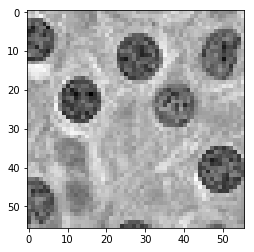

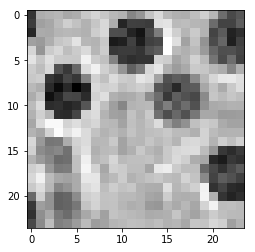

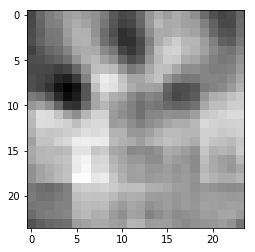

35.60947000980377

 next


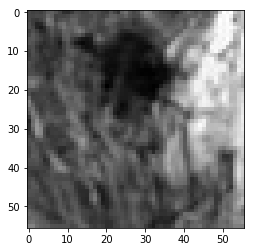

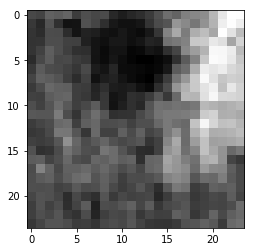

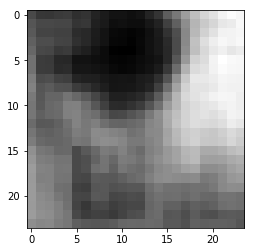

23.55431668460369

 next


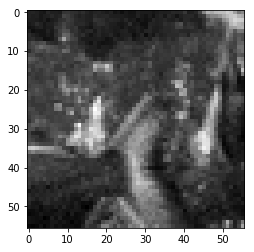

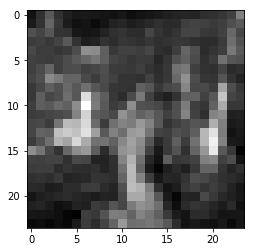

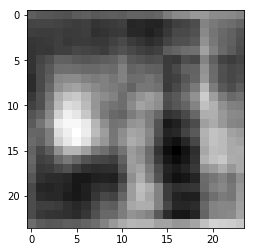

23.92579235136509

 next


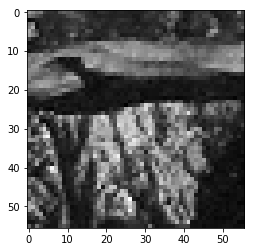

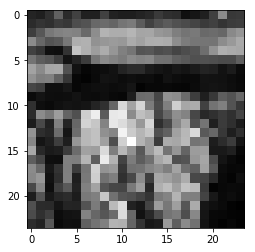

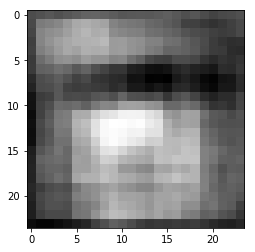

59.16456565260887

 next


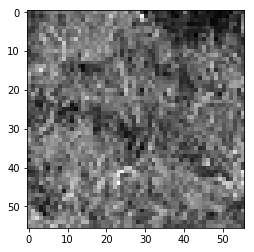

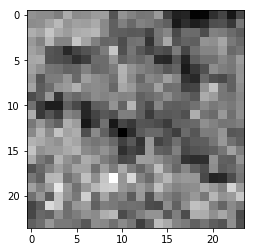

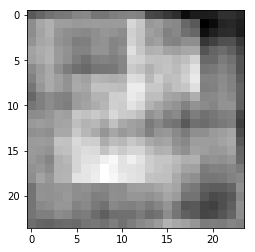

47.37604022026062

 next


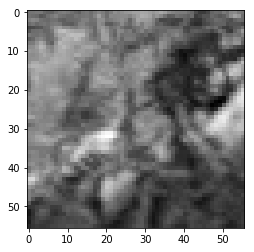

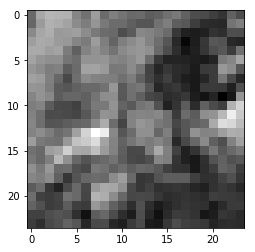

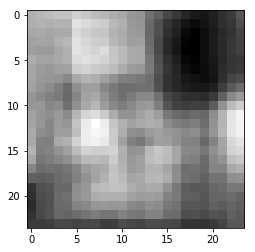

23.843640759587288

 next


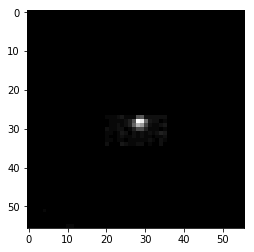

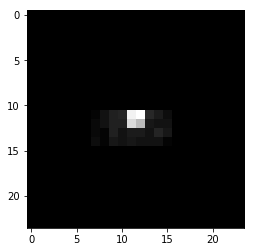

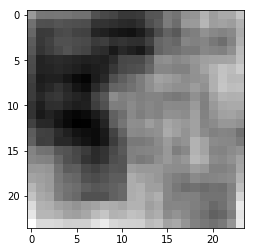

74.77951616048813

 next


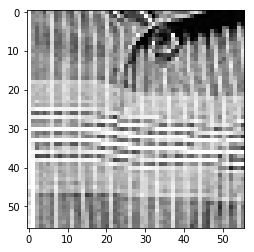

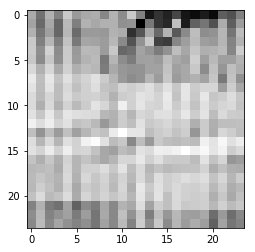

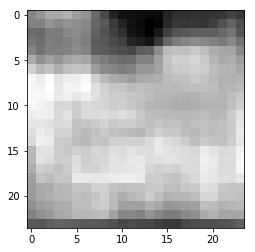

43.54525677859783

 next


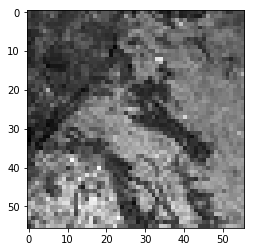

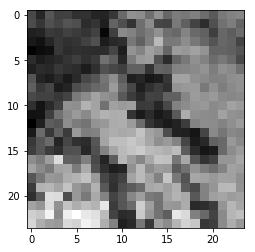

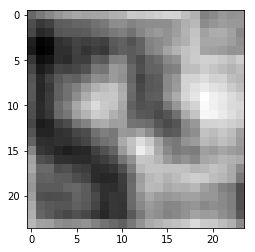

23.317008018493652

 next


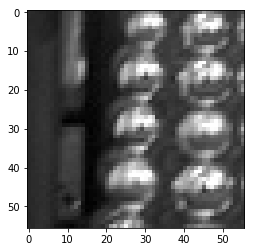

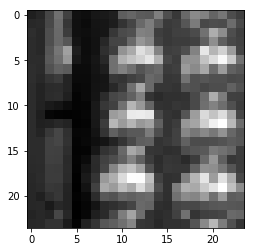

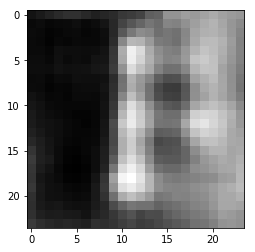

38.74212071299553

 next


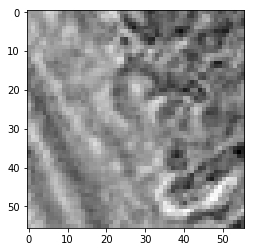

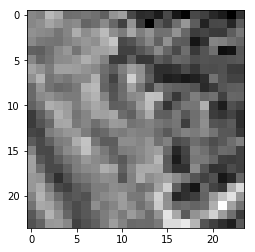

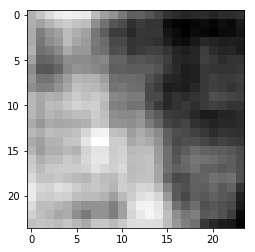

70.7992373406887

 next


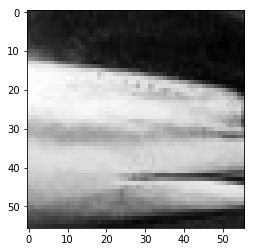

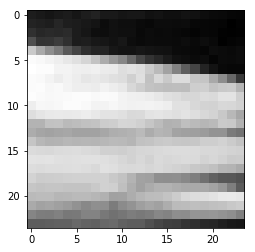

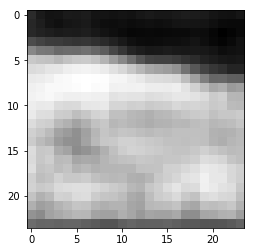

41.28096207976341

 next


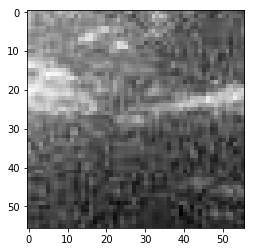

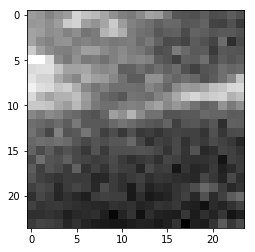

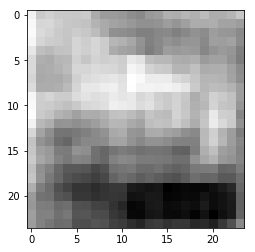

69.5995657145977

 next


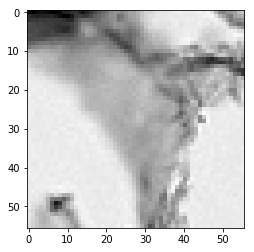

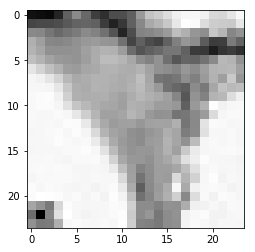

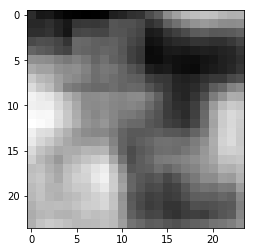

87.91600406169891

 next


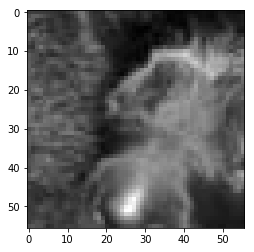

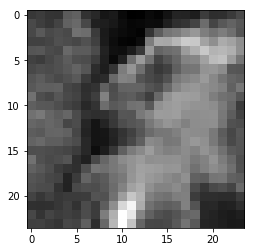

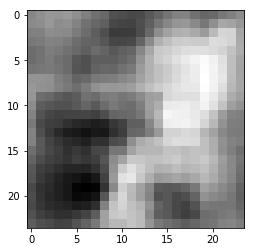

33.19996990263462

 next


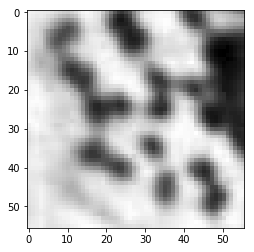

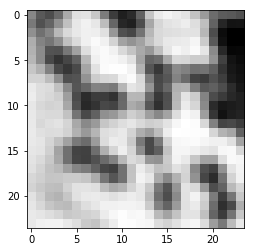

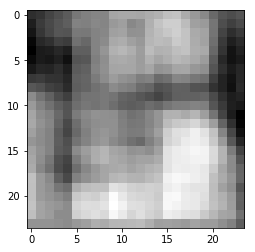

59.77568306028843

 next


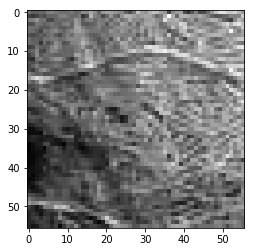

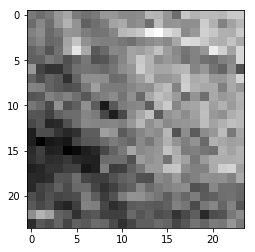

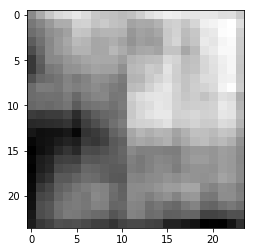

31.316228583455086

 next


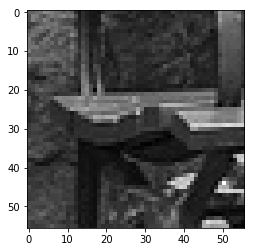

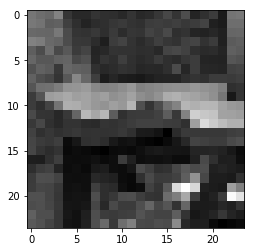

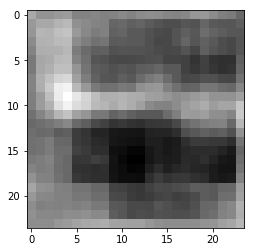

33.91808196902275

 next


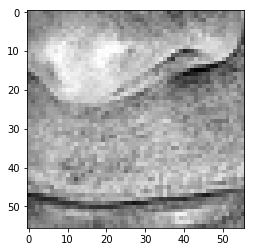

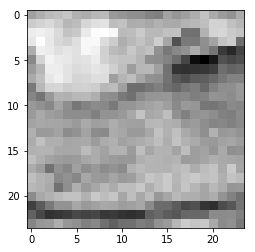

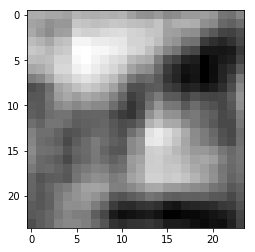

59.16800066828728

 next


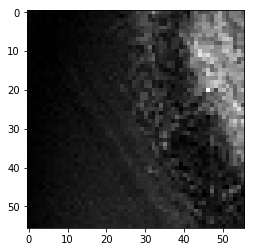

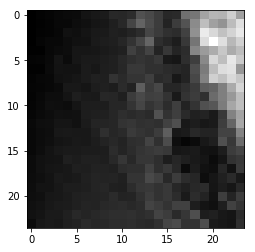

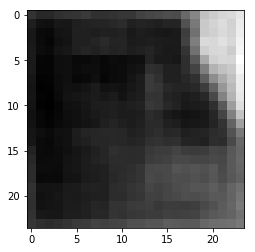

35.57323135435581

 next


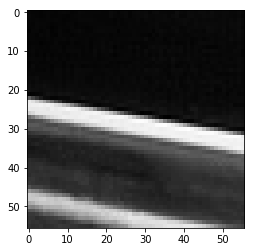

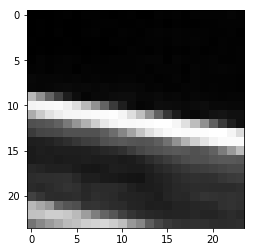

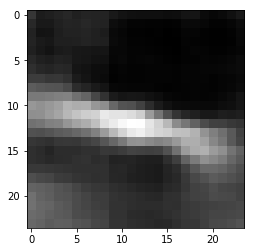

37.75863088667393

 next


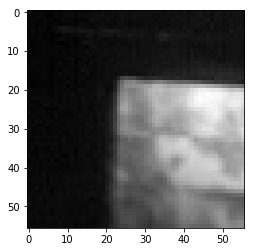

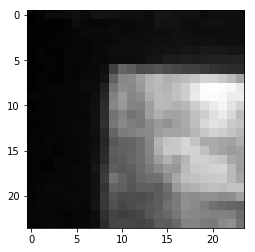

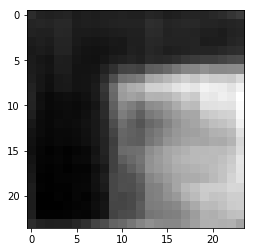

19.01447419077158

 next


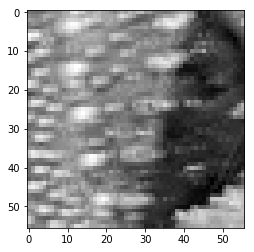

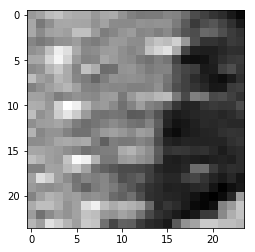

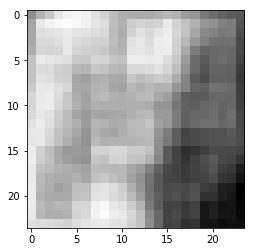

34.99390684068203

 next


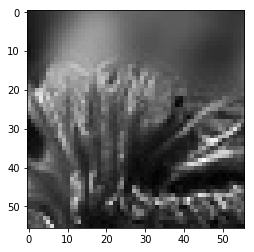

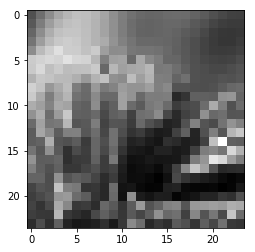

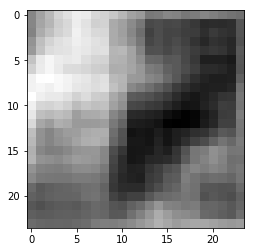

39.38793025910854

 next


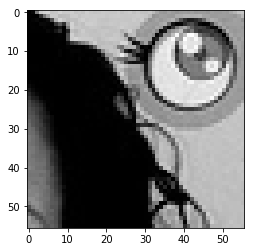

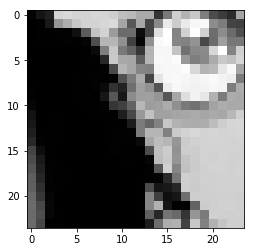

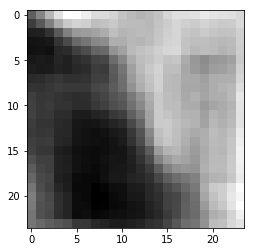

43.55389751493931

 next


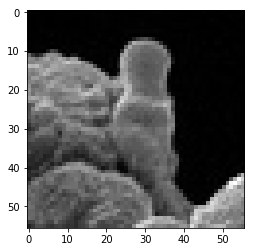

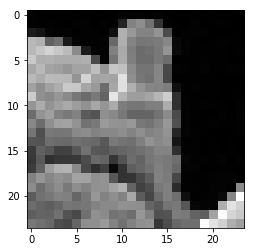

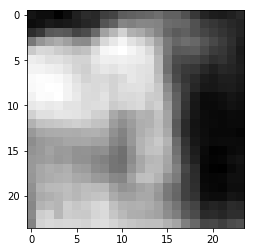

57.586913108825684

 next


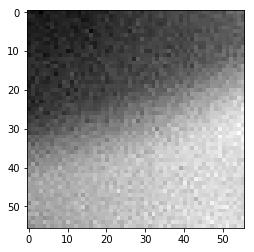

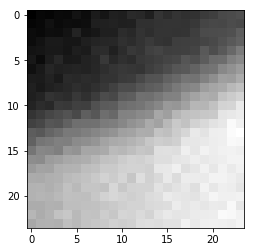

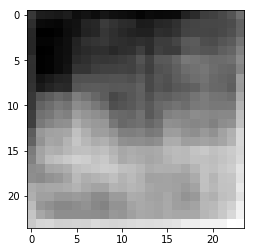

22.3054775968194

 next


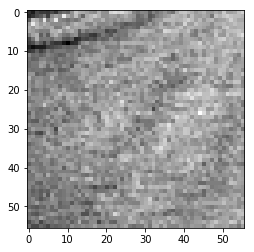

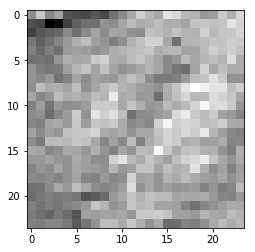

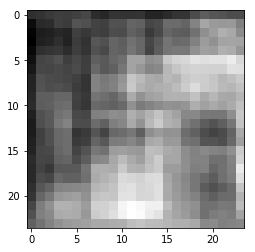

50.216232016682625

 next


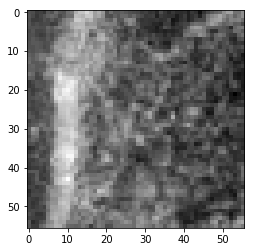

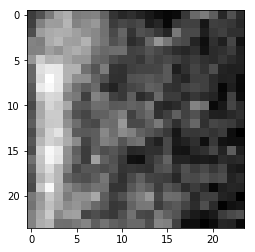

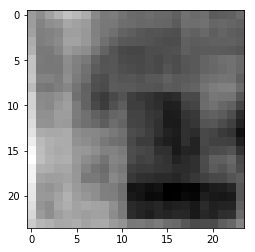

31.273602470755577

 next


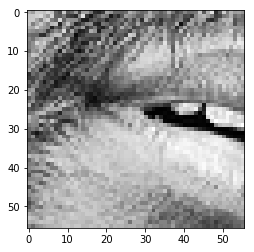

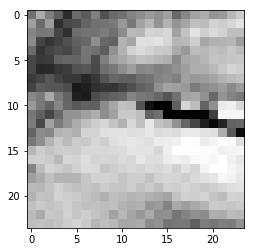

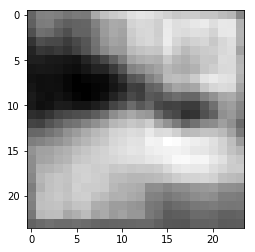

34.64638128876686

 next


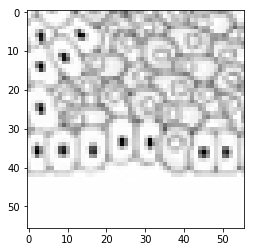

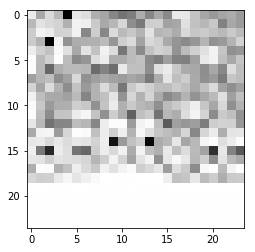

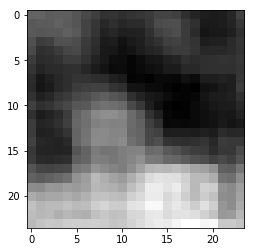

123.11179026961327

 next


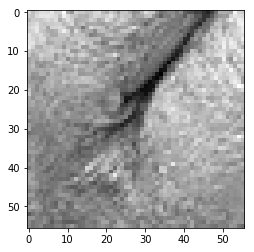

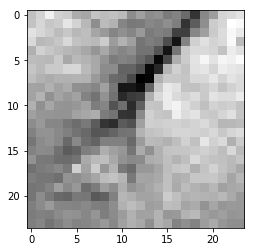

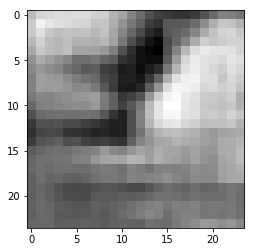

24.126130901277065

 next


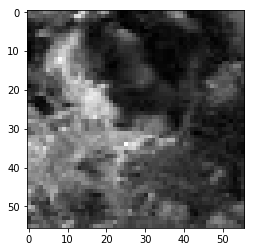

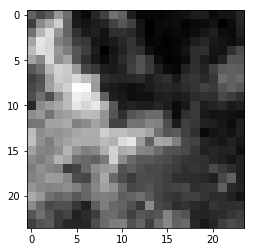

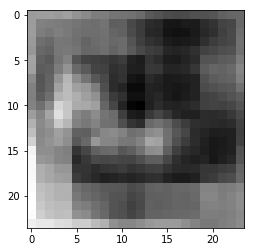

34.905037209391594

 next


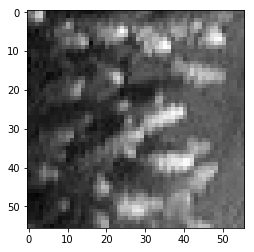

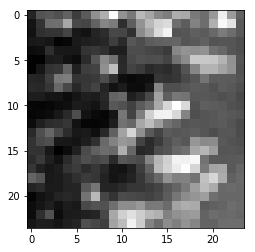

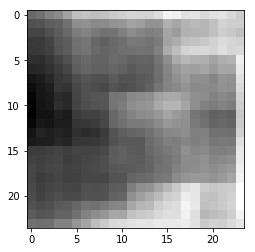

31.69422660022974

 next


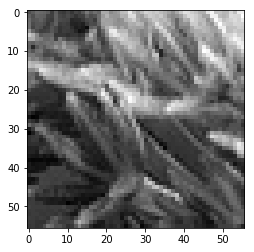

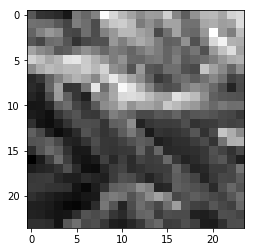

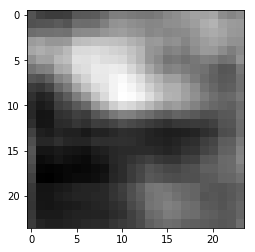

33.0512572824955

 next


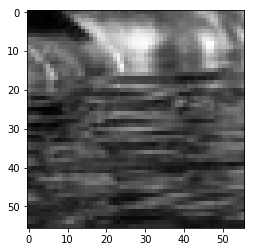

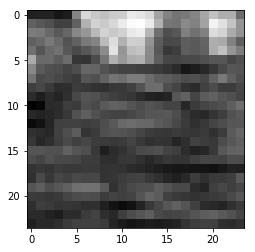

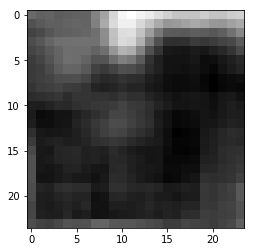

23.086527585983276

 next


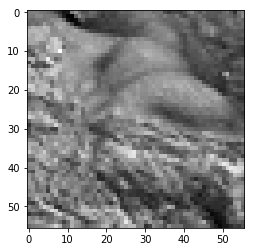

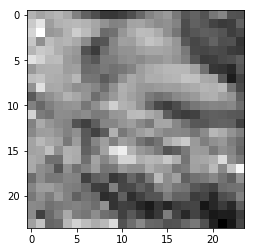

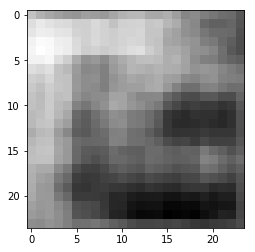

43.18384297192097

 next


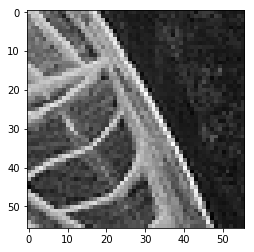

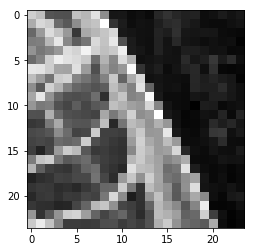

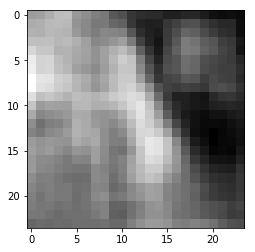

38.08255210518837

 next


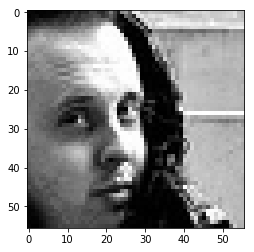

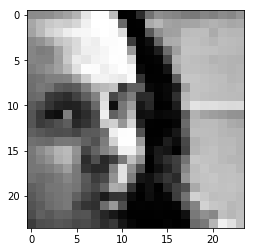

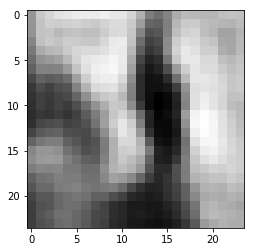

41.92036136984825

 next
0.16343742337077857


In [15]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)